# ImageNet Contrast Classification

This experiment will attempt to classify image contrast by extracting features from different layers of an Xception model. The Xception model will generate features for 128x128 px images, and a classifier will use those feature maps to predict contrast. Due to memory constraints, only layers past block 3 will be explored (until memory issues can be resolved).

## Setup

In [1]:
!nvidia-smi

Tue Sep 10 00:07:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:86:00.0 Off |                    0 |
| N/A   35C    P0             45W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install --upgrade pip

In [3]:
# !pip install tensorflow[and-cuda]

In [4]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-09-10 00:07:33.232373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 00:07:33.251857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 00:07:33.257911: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 00:07:33.272578: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 00:07:34.828209: W tensorflow/compiler/tf2

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [119]:
import numpy as np
import keras
from keras import layers, regularizers, mixed_precision
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.utils.class_weight import compute_class_weight
from time import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
import tensorflow as tf
import torch

In [7]:
!pwd
!ls koa_scratch

/home/jctactay
images


In [8]:
# # set mixed_float16 to decrease memory usage (?)
# mixed_precision.set_global_policy('mixed_float16')

## Data preprocessing

In [9]:
# load/reconcile labels
cols = ["species","image","contrast"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]

cols = ["species","filename","contrast"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","contrast"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)
target_labels = ['1', '3', '8']

In [10]:
print(len(labels))

3592


In [11]:
is_na = labels.contrast.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')
len(labels)

2696

In [12]:
for index, row in labels.iterrows():
    if row.contrast == 3.0:
       labels.at[index, 'contrast'] = 2
    elif row.contrast == 8.0:
        labels.at[index, 'contrast'] = 3

In [13]:
value_counts = labels.contrast.value_counts()
value_counts.index = pd.to_numeric(value_counts.index)
value_counts = value_counts.sort_index()
value_counts

contrast
1.0    1475
2.0    1218
3.0       3
Name: count, dtype: int64

In [14]:
paths = []
for index, row in labels.iterrows():
    paths.append("/home/jctactay/koa_scratch/images/" + row.image)
assert len(labels) == len(paths)

In [15]:
# image reading/processing
def load_img(path):
    img = Image.open(path)
    img = img.resize((128,128))
    np_img = np.array(img)/127.5 - 1
    return os.path.basename(path), np_img
def load_images_into_dict():
    imgs = {}

    num_workers = 8
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_img = {executor.submit(load_img, path): path for path in paths}

        for future in as_completed(future_to_img):
            img_name, img = future.result()
            imgs[img_name] = img

    return imgs
    
t0 = time()

imgs = load_images_into_dict()
print(f"Done in {time() - t0: .3f}s")

Done in  152.484s


In [16]:
assert len(imgs) == len(labels)

In [17]:
# check for nans
for k, v in zip(imgs.keys(), imgs.values()):
    if np.isnan(v.any()):
        print(k)

In [18]:
print(labels)

                       species                           image  contrast
6     short_finned_pilot_whale              01614d81068ff6.jpg       1.0
10    short_finned_pilot_whale              0246806606bc80.jpg       1.0
15    short_finned_pilot_whale              029eef21f79e91.jpg       1.0
16    short_finned_pilot_whale              02e6e47b13575a.jpg       2.0
17    short_finned_pilot_whale              030acd6311f20a.jpg       1.0
...                        ...                             ...       ...
3587        melon_headed_whale  PIFSC_20110503-S3_C-5088a-.jpg       2.0
3588        melon_headed_whale  PIFSC_20110503-S3_Z-3913a-.jpg       1.0
3589        melon_headed_whale  PIFSC_20110503-S3_Z-3914ed.jpg       1.0
3590        melon_headed_whale  PIFSC_20110503-S3_C-4846a-.jpg       1.0
3591        melon_headed_whale  PIFSC_20110503-S3_Z-3866ed.jpg       2.0

[2696 rows x 3 columns]


In [19]:
Y = labels.contrast
if min(np.unique(Y)) != 0:
    for i in range(len(Y)):
        Y.iat[i] -= 1
print(np.unique(Y))
X = np.array([imgs[i] for i in labels.image])
print(len(Y))
print(len(X))

[0. 1. 2.]
2696
2696


## Xception model

In [20]:
# load pretrained model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False)
# freeze base model
base_model.trainable = False
base_model.summary(show_trainable=True)

2024-09-10 00:10:12.538609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 63, 63,  │       864 │ input_layer[0… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 63, 63,  │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 63, 63,  │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 61, 61,  │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 61, 61,  │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 61, 61,  │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 61, 61,  │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 61, 61,  │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 31, 31,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 31, 31,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 31, 31,  │       512 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 31, 31,  │         0 │ block2_pool[0… │   -   │
│                   │ 128)            │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_sepconv1_… │ (None, 31, 31,  │         0 │ add[0][0]      │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

## Helper functions

In [21]:
def plot_history(histories):
    num_subplots = len(histories[0].history.keys())//2 * len(histories)
    fig = plt.figure(figsize=(10,10))
    subfigs = fig.subfigures(num_subplots//2)
    for i, history in enumerate(histories):
        ax = subfigs[i].subplots(1, 2)
        f = 0
        subfigs[i].suptitle(f"Fold {i+1}")
        for metric in history.history.keys():
            ax[f].plot(history.history[metric], label=metric)
            ax[f].legend()
            f = int(not f)

In [22]:
def extract_features(layer_name):
    extractor = keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
    features = extractor.predict(X)
    return features

In [104]:
def build_model(model_arg=None, features=None, num_classes=3):
    if model_arg is None:
        model = keras.Sequential([
            tf.keras.Input(shape=features.shape[1:]),
            keras.layers.Flatten(),
            # keras.layers.Dense(1024, activation='relu'),
            # keras.layers.Dropout(0.3),
            keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(num_classes, activation='softmax')
        ])
    optimizer = keras.optimizers.Adam(1e-5)
    # optimizer = mixed_precision.LossScaleOptimizer(optimizer)

    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [110]:
def extract_train_predict_cv(layer_name, callback_arg=None, model_arg=None, n_splits=5):
    features = extract_features(layer_name)
    print("Shape of features:", features.shape)
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    classes = np.unique(Y)
    num_classes = len(classes)
    fold_no = 1
    all_preds = np.zeros((X.shape[0], num_classes))
    histories = []
    for train_index, val_index in cv.split(X=features,y=Y):
        model = build_model(model_arg, features, num_classes)
        if callback_arg is None:
            callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)
        print(f'Training on fold {fold_no}...')
        X_train, X_val = features[train_index], features[val_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
        print("Class weights:", class_weights)
        class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
        sample_weights = np.array([class_weights_dict[label] for label in Y_train])
        history = model.fit(X_train, Y_train, batch_size=32, epochs=30, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)
        histories.append(history)
        pred_soft = model.predict(X_val)
        all_preds[val_index] = pred_soft
        fold_no += 1
    preds = np.argmax(all_preds, axis=1)
    report = classification_report(Y, preds, target_names=target_labels)
    cm = confusion_matrix(Y, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
    # model.save('extractor_predictor_64.keras')
    return histories, report, disp

In [25]:
def extract_train_predict_cv_2(layer_name, model, n_splits=5):
    features = extract_features(layer_name)
    print("Shape of features:", features.shape)
    num_samples = features.shape[0]
    height, width, channels = features.shape[1], features.shape[2], features.shape[3]
    flattened_features = features.reshape(num_samples, height * width * channels)
    print("Shape of flattened features:", flattened_features.shape)
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    # classes = np.unique(Y)
    # num_classes = len(classes)
    # fold_no = 1
    # all_preds = np.zeros((X.shape[0], num_classes))
    # for train_index, val_index in cv.split(X=flattened_features,y=Y):
    #     print(f'Training on fold {fold_no}...')
    #     X_train, X_val = flattened_features[train_index], flattened_features[val_index]
    #     Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]
    #     model.fit(X_train, Y_train)
    #     pred_soft = model.predict(X_val)
    #     all_preds[val_index] = pred_soft
    #     fold_no += 1
    # preds = np.argmax(all_preds, axis=1)
    preds = cross_val_predict(model, flattened_features, Y, cv=cv, n_jobs=-1, verbose=2)
    report = classification_report(Y, preds, target_names=target_labels)
    cm = confusion_matrix(Y, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
    return report, disp

In [26]:
def plot_feature_maps(feature_maps):
    num_features = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    num_cols = 8
    num_rows = num_features // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))
    for i in range(num_features):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(feature_maps[0, :, :, i])
        ax.axis('off')
    plt.show()

## block5_sepconv1_act (baseline)

Treat this layer as the baseline based on overall feature extraction experiment

In [111]:
histories, report, disp = extract_train_predict_cv('block5_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [  0.6093591    0.73768473 299.5       ]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5406 - loss: 3.8536 - val_accuracy: 0.6652 - val_loss: 0.7900
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6242 - loss: 1.3649 - val_accuracy: 0.6385 - val_loss: 0.8429
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6147 - loss: 1.2232 - val_accuracy: 0.7175 - val_loss: 0.7490
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6902 - loss: 0.6805 - val_accuracy: 0.7175 - val_loss: 0.7452
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7059 - loss: 0.5763 - val_accuracy: 0.7164 - val_loss: 0.7336
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7211 - loss: 0.6454 - val_accuracy: 0.7186 - val_loss: 0.7246
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7411 - loss: 0.5415 - va

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

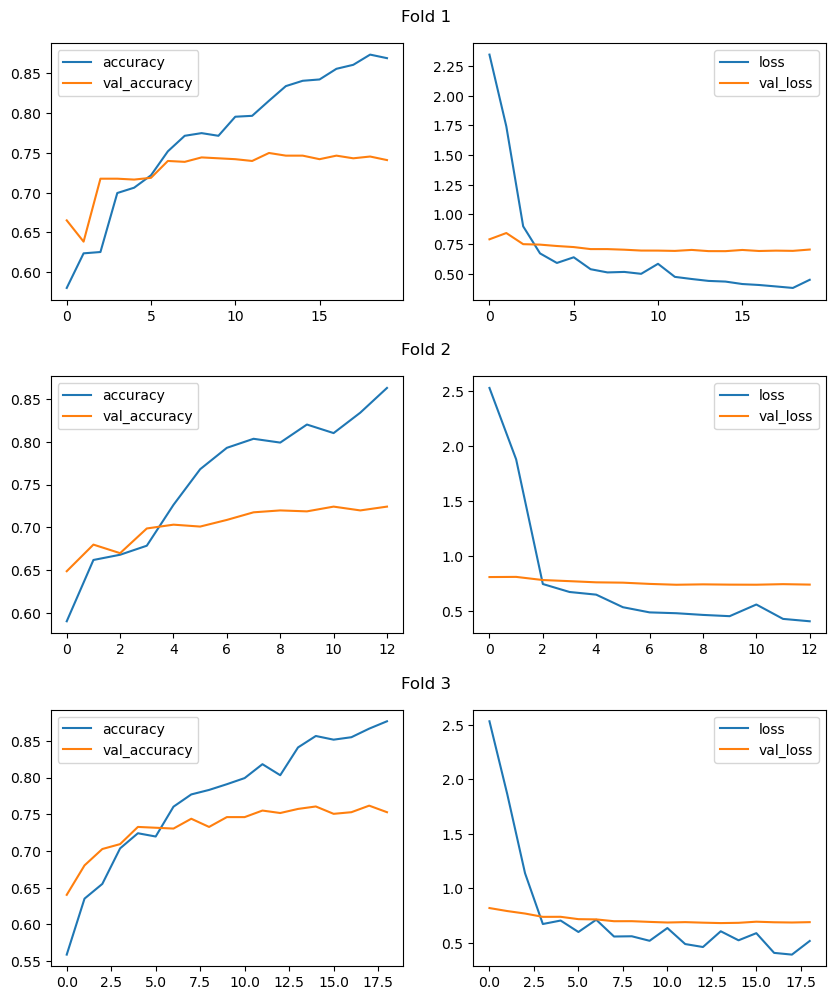

In [112]:
plot_history(histories)

In [113]:
print(report)

              precision    recall  f1-score   support

         0.0       0.74      0.81      0.77      1475
         1.0       0.74      0.66      0.70      1218
         2.0       0.00      0.00      0.00         3

    accuracy                           0.74      2696
   macro avg       0.49      0.49      0.49      2696
weighted avg       0.74      0.74      0.74      2696



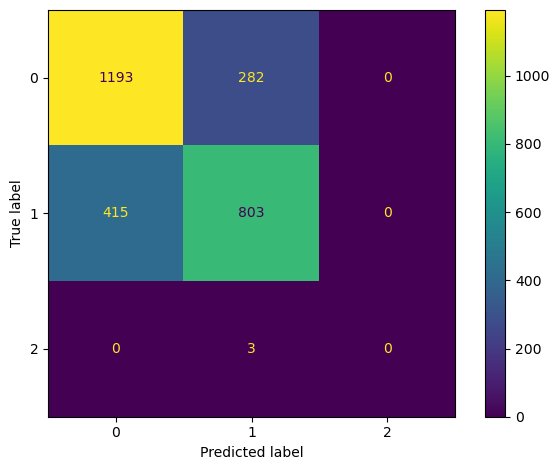

In [114]:
disp.plot()
plt.tight_layout()

## block5_sepconv1

In [44]:
histories, report, disp = extract_train_predict_cv('block5_sepconv1', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [  0.6093591    0.73768473 299.5       ]
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5409 - loss: 685.9196 - val_accuracy: 0.6107 - val_loss: 3.1195
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4969 - loss: 99.9739 - val_accuracy: 0.7130 - val_loss: 1.7341
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5483 - loss: 122.4887 - val_accuracy: 0.6429 - val_loss: 1.1490
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3570 - loss: 130.8839 - val_accuracy: 0.5706 - val_loss: 1.2309
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4828 - loss: 19.3318 - val_accuracy: 0.4516 - val_loss: 2.0010
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5255 - loss: 3.2639 - val_accuracy: 0.5806 - val_loss: 0.9995
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5660 - loss: 3

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

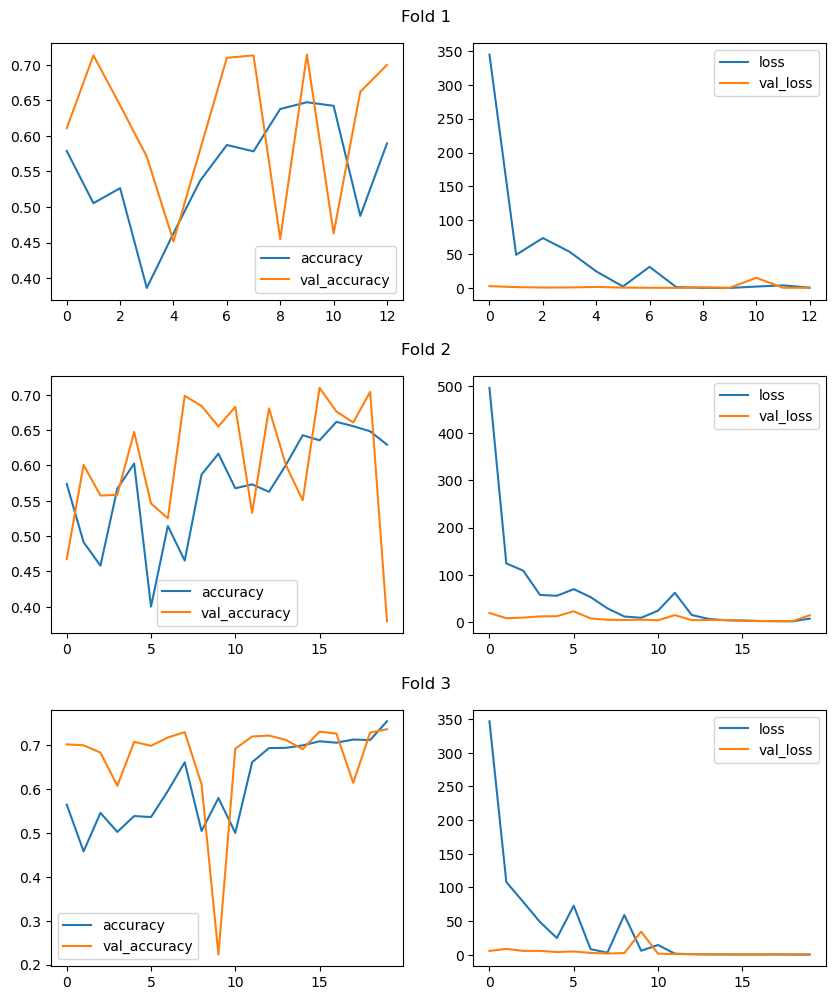

In [45]:
plot_history(histories)

In [46]:
print(report)

              precision    recall  f1-score   support

         0.0       0.70      0.83      0.76      1475
         1.0       0.73      0.58      0.65      1218
         2.0       0.00      0.00      0.00         3

    accuracy                           0.71      2696
   macro avg       0.48      0.47      0.47      2696
weighted avg       0.72      0.71      0.71      2696



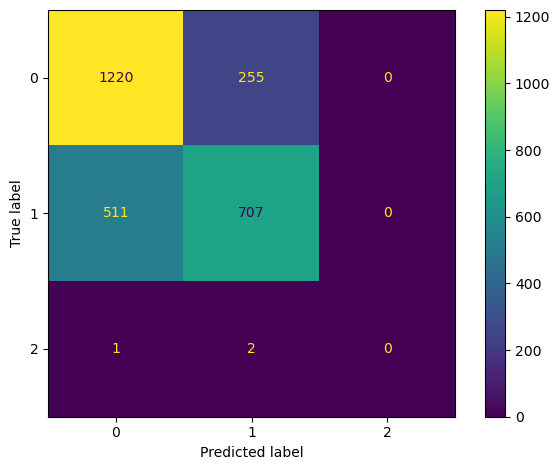

In [48]:
disp.plot()
plt.tight_layout()

## block5_sepconv1_bn

In [34]:
histories, report, disp = extract_train_predict_cv('block5_sepconv1_bn', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [  0.6093591    0.73768473 299.5       ]
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5692 - loss: 360.2686 - val_accuracy: 0.4816 - val_loss: 14.0675
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5847 - loss: 50.1790 - val_accuracy: 0.4905 - val_loss: 7.0702
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5691 - loss: 30.6279 - val_accuracy: 0.7130 - val_loss: 2.9323
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5188 - loss: 175.3081 - val_accuracy: 0.6941 - val_loss: 3.9649
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6338 - loss: 4.7120 - val_accuracy: 0.5729 - val_loss: 3.5904
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6326 - loss: 2.6312 - val_accuracy: 0.7475 - val_loss: 1.3364
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6310 - loss: 12.

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

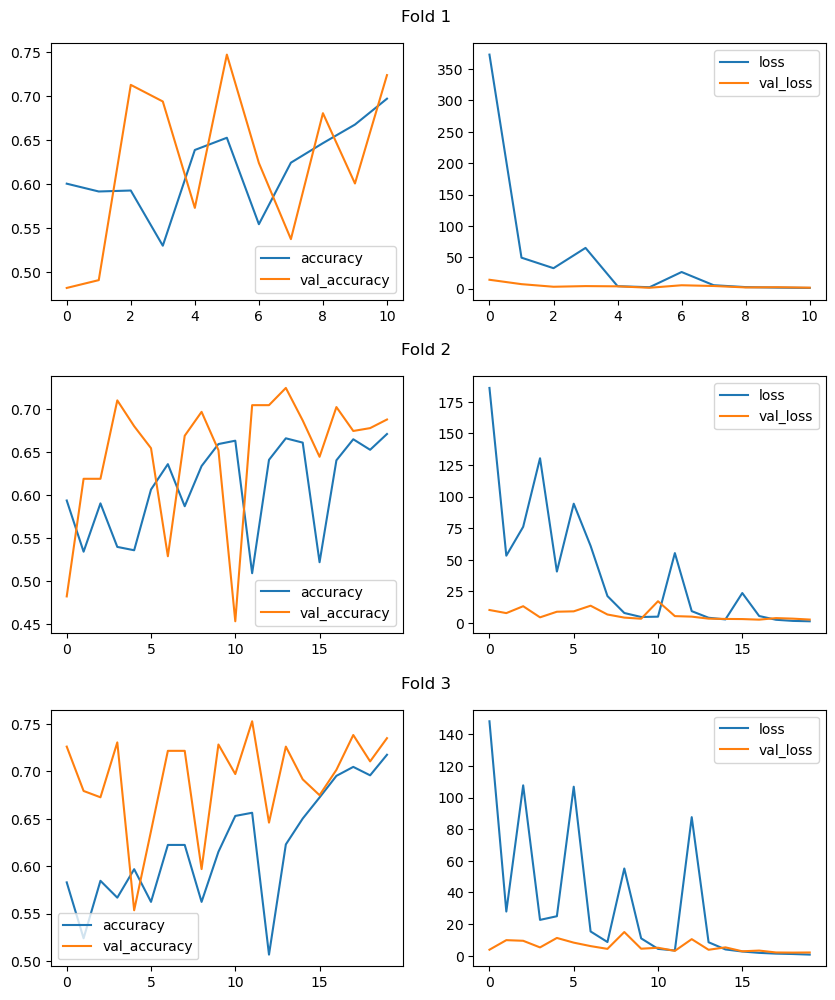

In [35]:
plot_history(histories)

In [36]:
print(report)

              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74      1475
         1.0       0.68      0.71      0.70      1218
         2.0       0.00      0.00      0.00         3

    accuracy                           0.72      2696
   macro avg       0.48      0.48      0.48      2696
weighted avg       0.72      0.72      0.72      2696



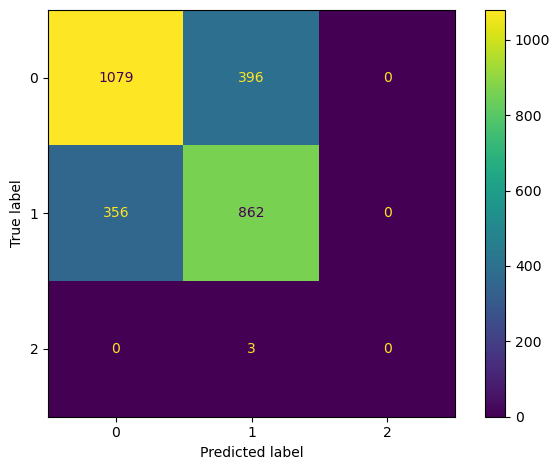

In [37]:
disp.plot()
plt.tight_layout()

## block4_sepconv1_act

In [39]:
torch.cuda.empty_cache()

In [40]:
histories, report, disp = extract_train_predict_cv('block4_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Shape of features: (2696, 16, 16, 256)
Training on fold 1...
Class weights: [  0.6093591    0.73768473 299.5       ]
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4970 - loss: 1253.5886 - val_accuracy: 0.6107 - val_loss: 13.3588
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4797 - loss: 501.0465 - val_accuracy: 0.5473 - val_loss: 48.0154
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4894 - loss: 141.7743 - val_accuracy: 0.6752 - val_loss: 11.7421
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4918 - loss: 162.3721 - val_accuracy: 0.6596 - val_loss: 8.0607
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4983 - loss: 62.6766 - val_accuracy: 0.4472 - val_loss: 102.0757
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4112 - loss: 72.9608 - val_accuracy: 0.6563 - val_loss: 9.1910
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.48

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

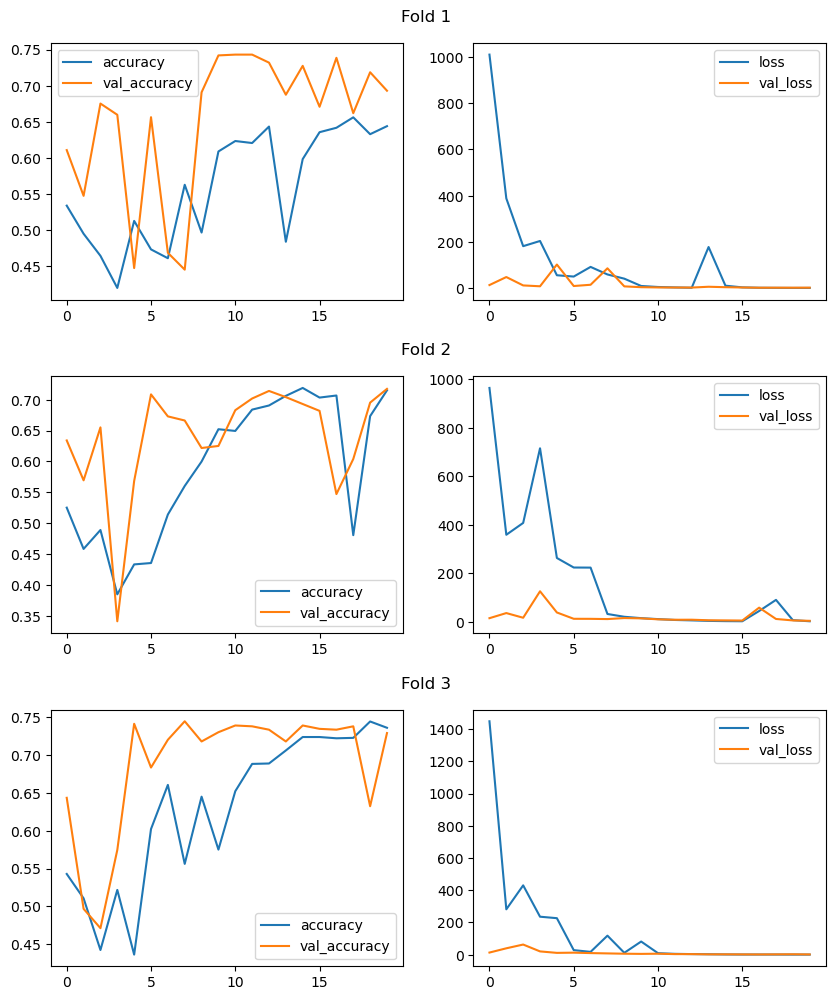

In [41]:
plot_history(histories)

In [42]:
print(report)

              precision    recall  f1-score   support

         0.0       0.73      0.81      0.77      1475
         1.0       0.73      0.64      0.68      1218
         2.0       0.00      0.00      0.00         3

    accuracy                           0.73      2696
   macro avg       0.49      0.48      0.48      2696
weighted avg       0.73      0.73      0.73      2696



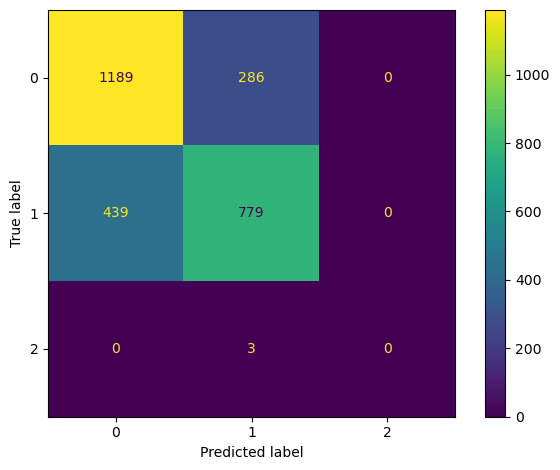

In [43]:
disp.plot()
plt.tight_layout()

## block4_sepconv2_act

In [49]:
histories, report, disp = extract_train_predict_cv('block4_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Shape of features: (2696, 16, 16, 728)
Training on fold 1...
Class weights: [  0.6093591    0.73768473 299.5       ]
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.5081 - loss: 571.3256 - val_accuracy: 0.5751 - val_loss: 9.8320
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6353 - loss: 22.4121 - val_accuracy: 0.6285 - val_loss: 3.2237
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6951 - loss: 22.4384 - val_accuracy: 0.6507 - val_loss: 3.5733
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7455 - loss: 1.3596 - val_accuracy: 0.7364 - val_loss: 1.1220
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7623 - loss: 46.6056 - val_accuracy: 0.6340 - val_loss: 2.6449
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7596 - loss: 0.9252 - val_accuracy: 0.7063 - val_loss: 1.1858
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7530 - loss

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

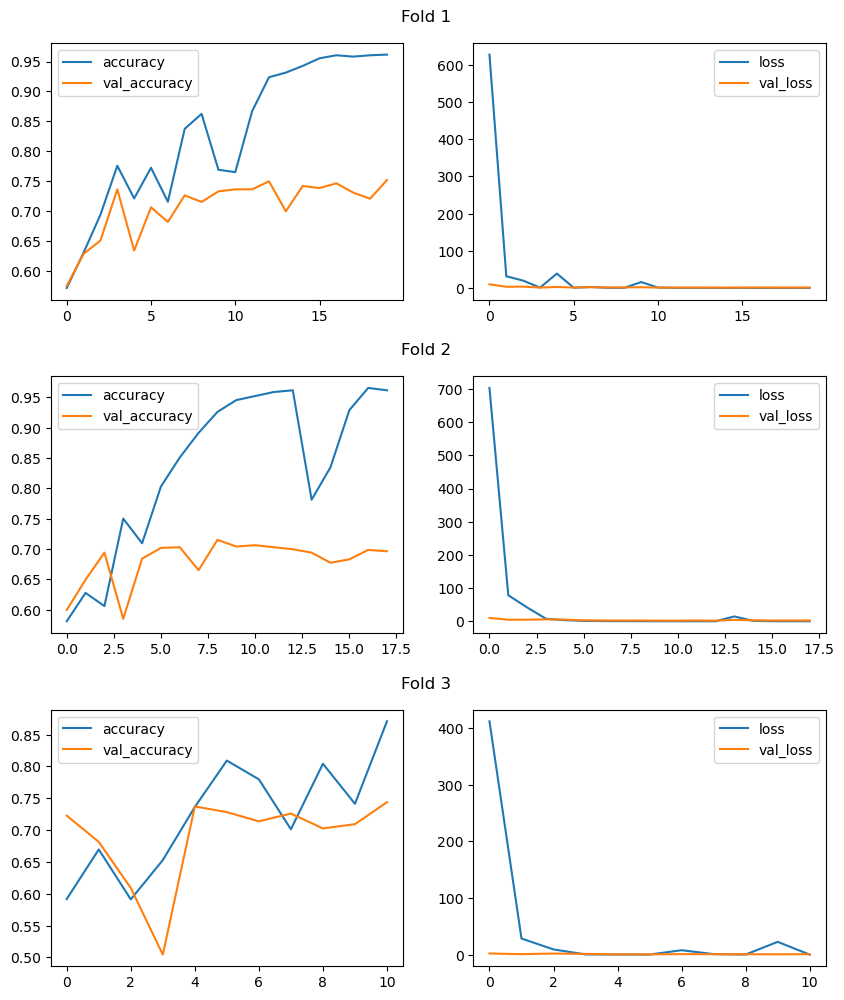

In [50]:
plot_history(histories)

In [51]:
print(report)

              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75      1475
         1.0       0.70      0.68      0.69      1218
         2.0       0.00      0.00      0.00         3

    accuracy                           0.72      2696
   macro avg       0.48      0.48      0.48      2696
weighted avg       0.72      0.72      0.72      2696



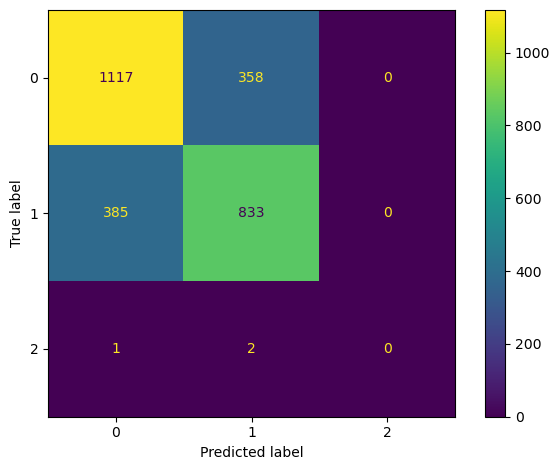

In [52]:
disp.plot()
plt.tight_layout()

## block11_sepconv1_act

In [27]:
history, report, disp = extract_train_predict_cv('block11_sepconv1_act', n_splits=3)

I0000 00:00:1725927089.030304 1280532 service.cc:146] XLA service 0x1478a0001f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725927089.030351 1280532 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-09-10 00:11:29.063111: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-10 00:11:29.331642: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


17/85 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

I0000 00:00:1725927090.626847 1280532 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [  0.6093591    0.73768473 299.5       ]
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5749 - loss: 85.1034 - val_accuracy: 0.6819 - val_loss: 3.8075
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6372 - loss: 25.6239 - val_accuracy: 0.7241 - val_loss: 2.2163
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5990 - loss: 53.1547 - val_accuracy: 0.5973 - val_loss: 2.3713
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6078 - loss: 6.5286 - val_accuracy: 0.7075 - val_loss: 4.0481
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7145 - loss: 5.5481 - val_accuracy: 0.7264 - val_loss: 1.8588
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6701 - loss: 7.0100 - val_accuracy: 0.6908 - val_loss: 2.6277
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6638 - loss: 8.7003 

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

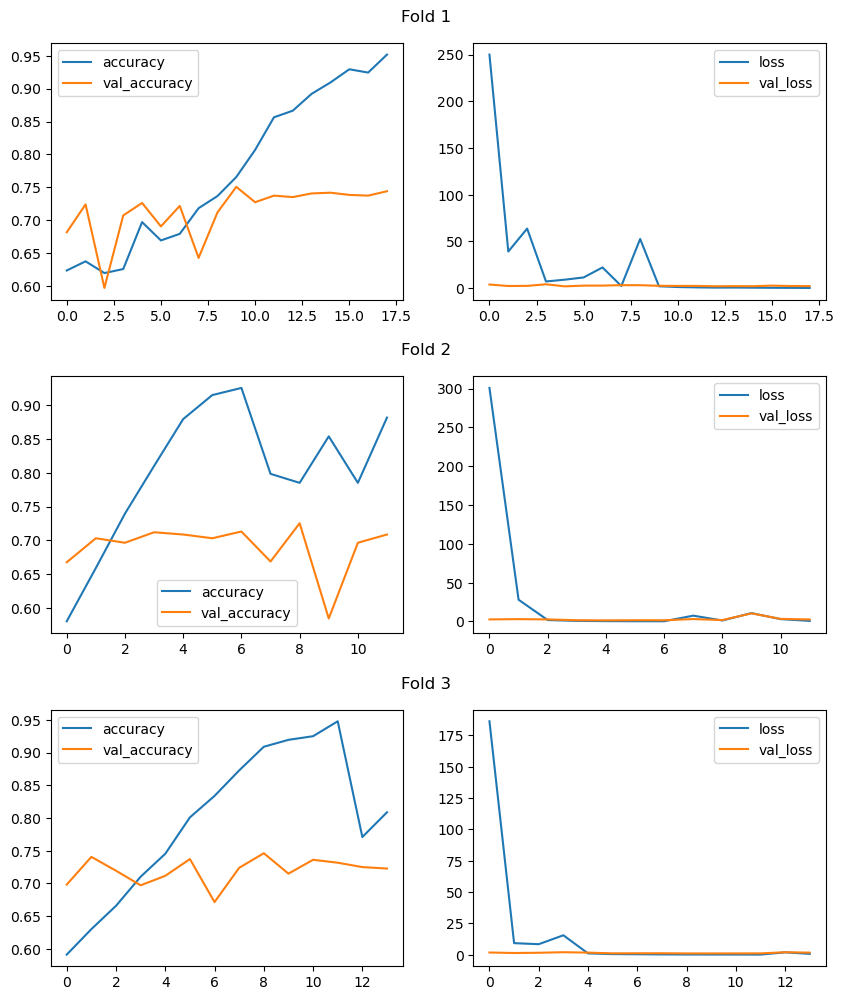

In [28]:
plot_history(history)

In [29]:
print(report)

              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76      1475
         1.0       0.72      0.67      0.69      1218
         2.0       0.00      0.00      0.00         3

    accuracy                           0.73      2696
   macro avg       0.49      0.48      0.49      2696
weighted avg       0.73      0.73      0.73      2696



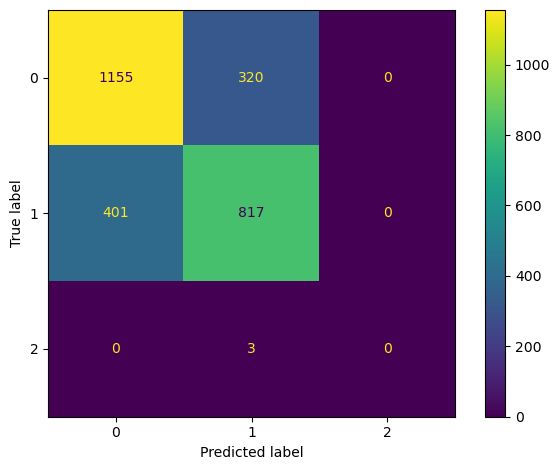

In [30]:
disp.plot()
plt.tight_layout()

## block8_sepconv1_act

In [31]:
history, report, disp = extract_train_predict_cv('block8_sepconv1_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [  0.6093591    0.73768473 299.5       ]
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5252 - loss: 170.9567 - val_accuracy: 0.7241 - val_loss: 4.2372
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5631 - loss: 42.3588 - val_accuracy: 0.7241 - val_loss: 2.6496
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5596 - loss: 23.4113 - val_accuracy: 0.7353 - val_loss: 2.6245
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6174 - loss: 4.9051 - val_accuracy: 0.7230 - val_loss: 1.7879
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6055 - loss: 21.7477 - val_accuracy: 0.7330 - val_loss: 2.7719
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6999 - loss: 2.2114 - val_accuracy: 0.7508 - val_loss: 1.4624
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6944 - loss: 15.08

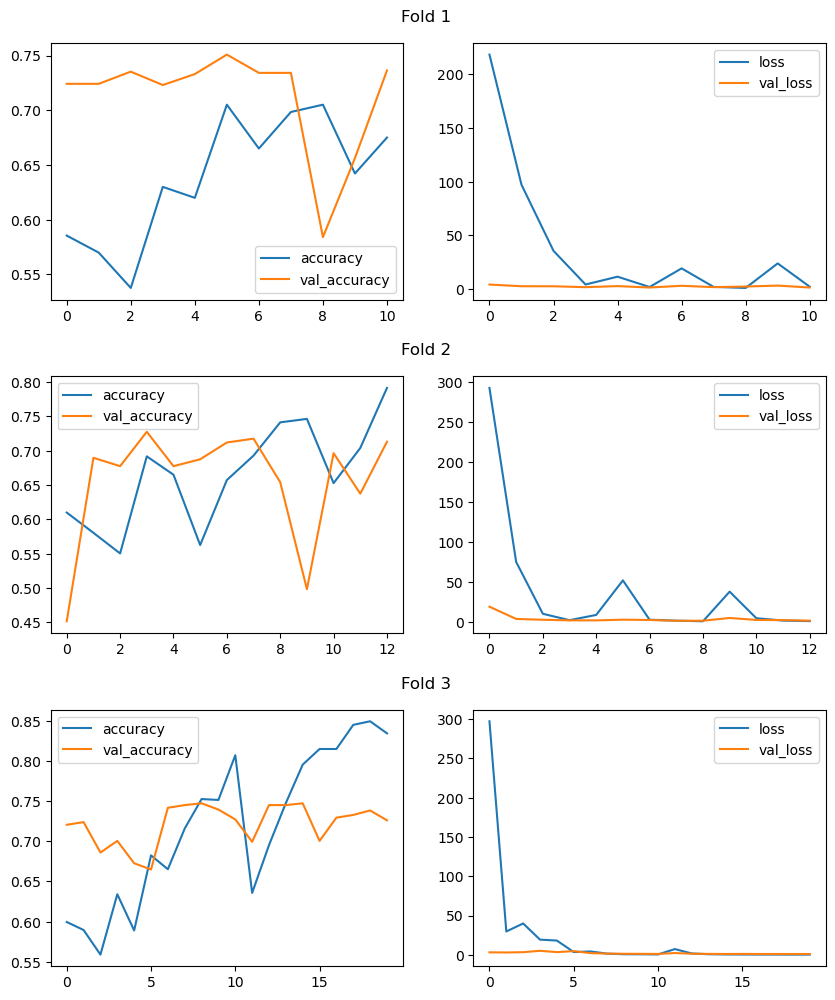

In [32]:
plot_history(history)

In [33]:
print(report)

              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77      1475
         1.0       0.72      0.67      0.70      1218
         2.0       0.00      0.00      0.00         3

    accuracy                           0.74      2696
   macro avg       0.49      0.49      0.49      2696
weighted avg       0.73      0.74      0.73      2696



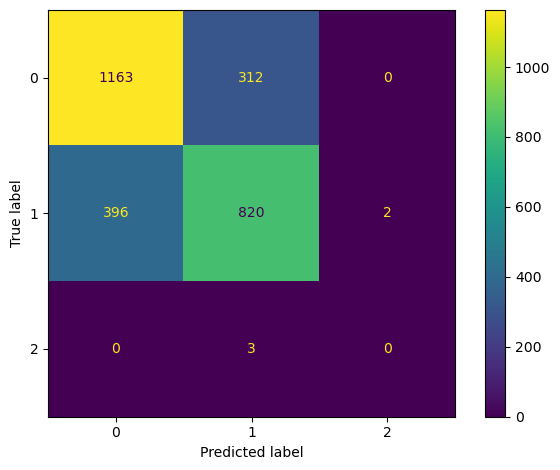

In [34]:
disp.plot()
plt.tight_layout()

## block6_sepconv2_act

In [37]:
history, report, disp = extract_train_predict_cv('block6_sepconv2_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [  0.6093591    0.73768473 299.5       ]
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5664 - loss: 81.6155 - val_accuracy: 0.6841 - val_loss: 1.7675
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6658 - loss: 4.4015 - val_accuracy: 0.7475 - val_loss: 0.7070
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6494 - loss: 2.3866 - val_accuracy: 0.7008 - val_loss: 0.8195
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6862 - loss: 0.9754 - val_accuracy: 0.7531 - val_loss: 0.7471
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7541 - loss: 3.5192 - val_accuracy: 0.7486 - val_loss: 0.8341
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7531 - loss: 2.4214 - val_accuracy: 0.7542 - val_loss: 0.7212
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7884 - loss: 0.6147 - 

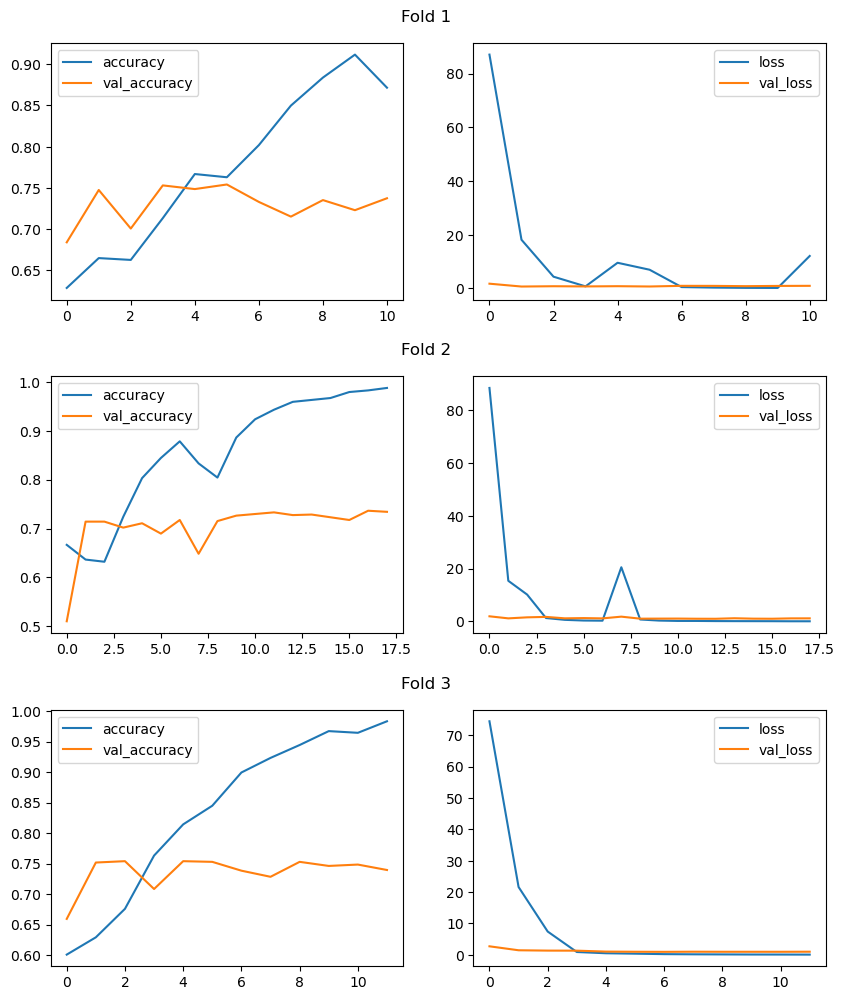

In [38]:
plot_history(history)

In [39]:
print(report)

              precision    recall  f1-score   support

         0.0       0.76      0.77      0.76      1475
         1.0       0.71      0.71      0.71      1218
         2.0       0.00      0.00      0.00         3

    accuracy                           0.74      2696
   macro avg       0.49      0.49      0.49      2696
weighted avg       0.74      0.74      0.74      2696



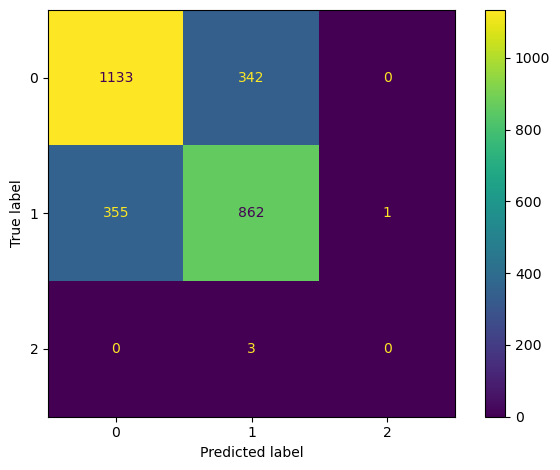

In [40]:
disp.plot()
plt.tight_layout()

## block6_sepconv3_act

In [106]:
histories, report, disp = extract_train_predict_cv('block6_sepconv3_act', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [  0.6093591    0.73768473 299.5       ]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5326 - loss: 1.5277 - val_accuracy: 0.7230 - val_loss: 0.7603
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7158 - loss: 0.8645 - val_accuracy: 0.7364 - val_loss: 0.7519
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7260 - loss: 0.6058 - val_accuracy: 0.7297 - val_loss: 0.7365
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7605 - loss: 0.6453 - val_accuracy: 0.7453 - val_loss: 0.7198
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7778 - loss: 0.5512 - val_accuracy: 0.7519 - val_loss: 0.7057
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7955 - loss: 0.5128 - val_accuracy: 0.7408 - val_loss: 0.7094
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7981 - loss: 0.5115 - va

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

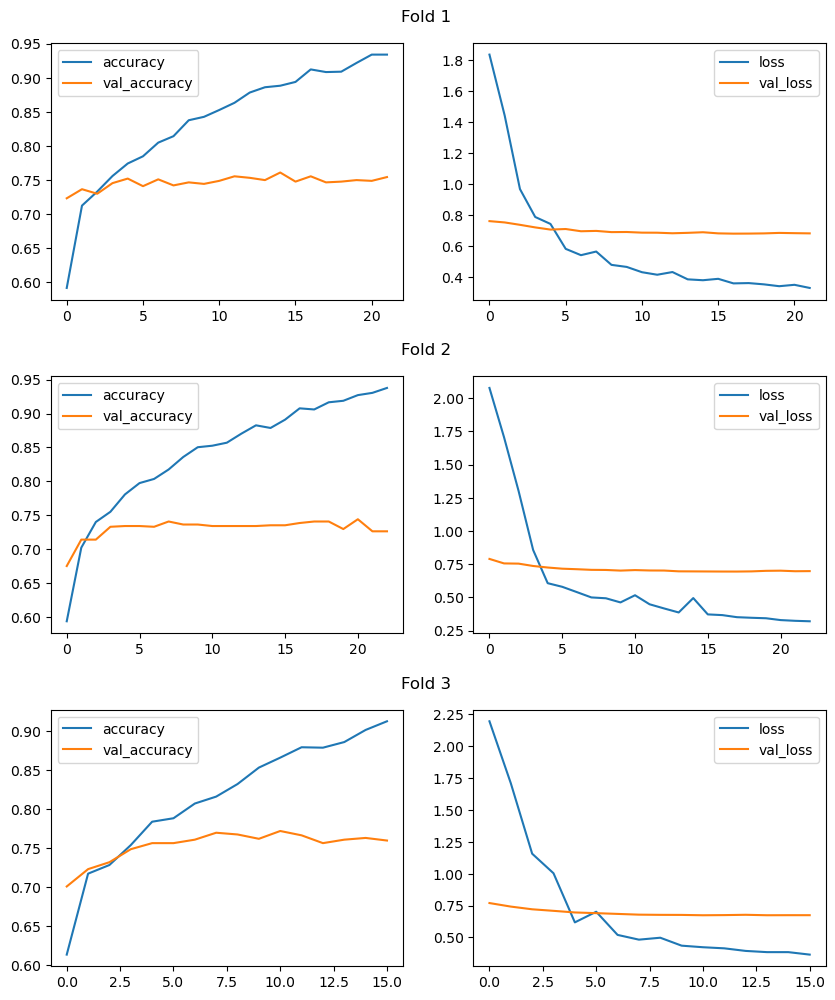

In [107]:
plot_history(histories)

In [108]:
print(report)

              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78      1475
         1.0       0.75      0.70      0.72      1218
         2.0       0.00      0.00      0.00         3

    accuracy                           0.76      2696
   macro avg       0.50      0.50      0.50      2696
weighted avg       0.75      0.76      0.75      2696



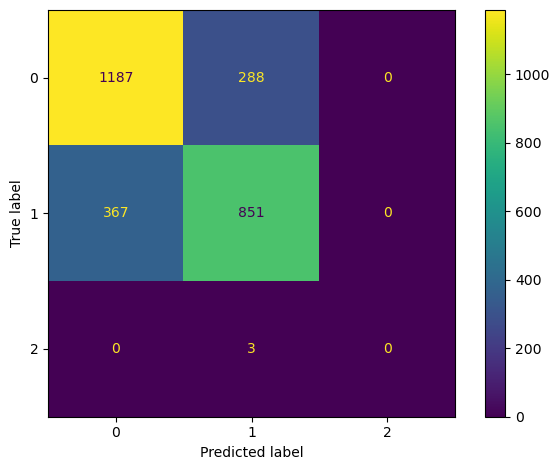

In [109]:
disp.plot()
plt.tight_layout()

## block6_sepconv3_bn

Compare corresponding batch normalization layer

In [115]:
histories, report, disp = extract_train_predict_cv('block6_sepconv3_bn', n_splits=3)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Shape of features: (2696, 8, 8, 728)
Training on fold 1...
Class weights: [  0.6093591    0.73768473 299.5       ]
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5036 - loss: 2.4310 - val_accuracy: 0.6874 - val_loss: 0.8362
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5971 - loss: 0.9360 - val_accuracy: 0.6630 - val_loss: 0.9139
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6043 - loss: 0.7877 - val_accuracy: 0.7152 - val_loss: 0.7698
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6424 - loss: 0.7071 - val_accuracy: 0.7264 - val_loss: 0.7688
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6556 - loss: 0.8462 - val_accuracy: 0.7241 - val_loss: 0.7715
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6823 - loss: 0.6334 - val_accuracy: 0.7063 - val_loss: 0.7478
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7241 - loss: 0.6002 - va

/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/apps/software/lang/Anaconda3/2024.02-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

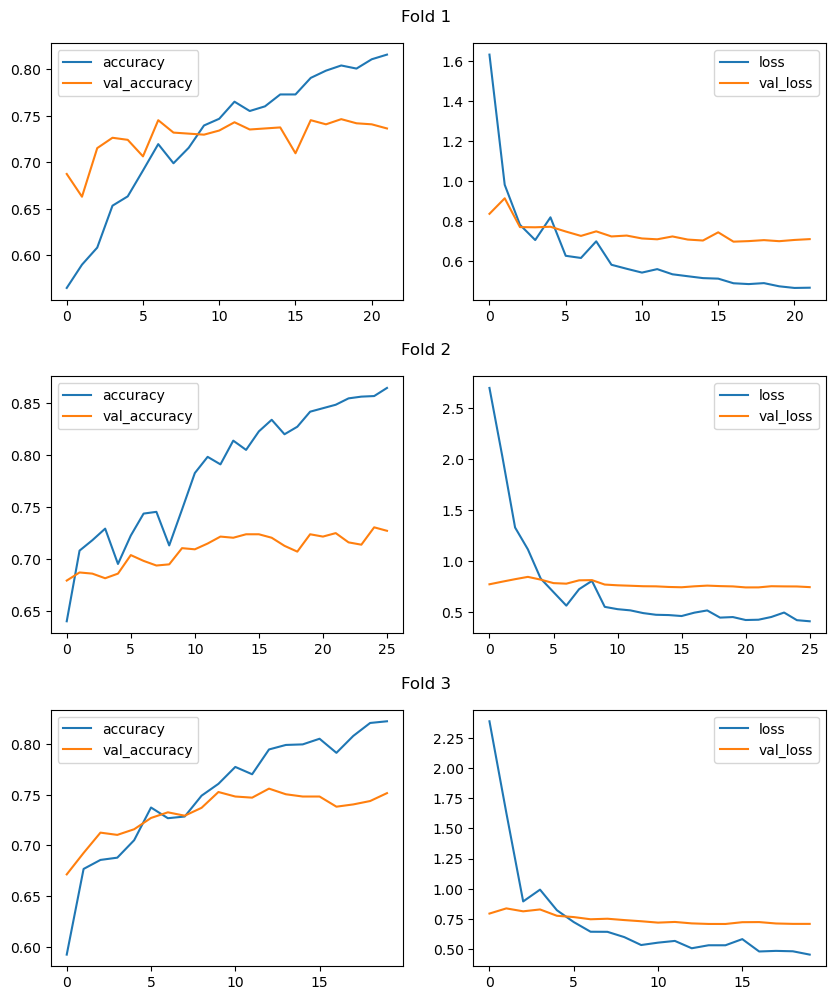

In [116]:
plot_history(histories)

In [117]:
print(report)

              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76      1475
         1.0       0.71      0.72      0.71      1218
         2.0       0.00      0.00      0.00         3

    accuracy                           0.74      2696
   macro avg       0.49      0.49      0.49      2696
weighted avg       0.74      0.74      0.74      2696



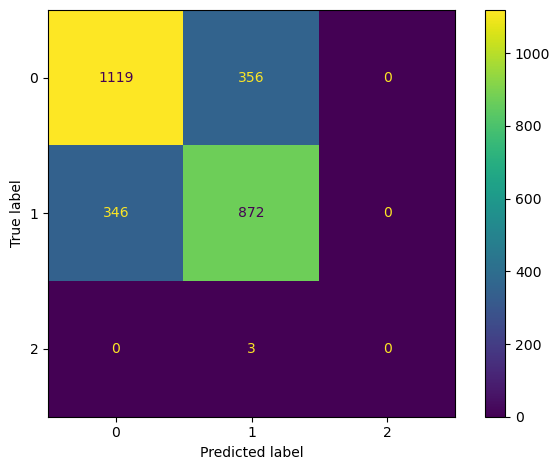

In [118]:
disp.plot()
plt.tight_layout()

## Next steps

Training will benefit from more low-contrast images. Potential next steps:

* Data augmentation
    * Find out how to decrease image contrast
    * Smote?
* Wait for more data
* Anomaly detection?
    * Train a binary detector for now?
* Explore more layers
    * Maybe iteratively train each activation layer on current classifier setup

Effort will focus on more balanced quality features in the meantime